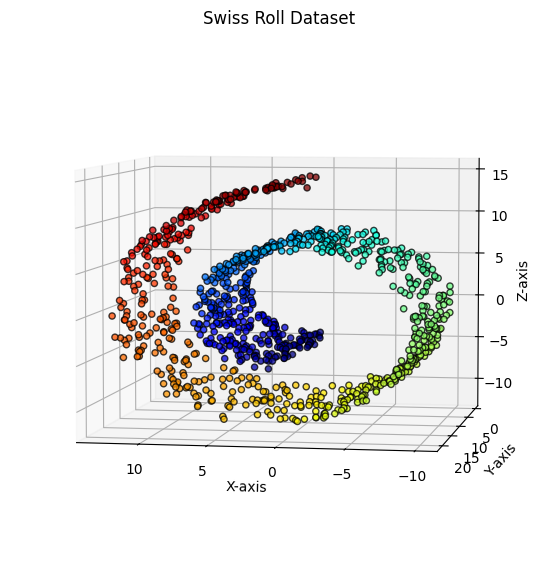

In [2]:
# The first thing to do is generate a swiss roll so we can test different tools for dimentionality reduction

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

# Set seed for reproducibility
np.random.seed(42)

# Generate 3D Swiss Roll dataset
# - n_samples: number of data points
# - noise: adds Gaussian noise for realism
X, t = make_swiss_roll(n_samples=1000, noise=0.2)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the Swiss Roll
# - c=t colors the points according to their unrolled position
# - cmap="jet" gives a smooth gradient color scheme
# - edgecolor='k' adds black borders to points
# - alpha controls point transparency
ax.scatter(X[:, 0], X[:, 1], X[:, 2],
           c=t, cmap=plt.get_cmap("jet"),
           edgecolor='k', alpha=0.75)

# Axis labels and plot title
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.set_title("Swiss Roll Dataset")

# Set viewing angle: elev controls elevation, azim controls rotation
ax.view_init(elev=5, azim=100)

# Display the plot
plt.show()

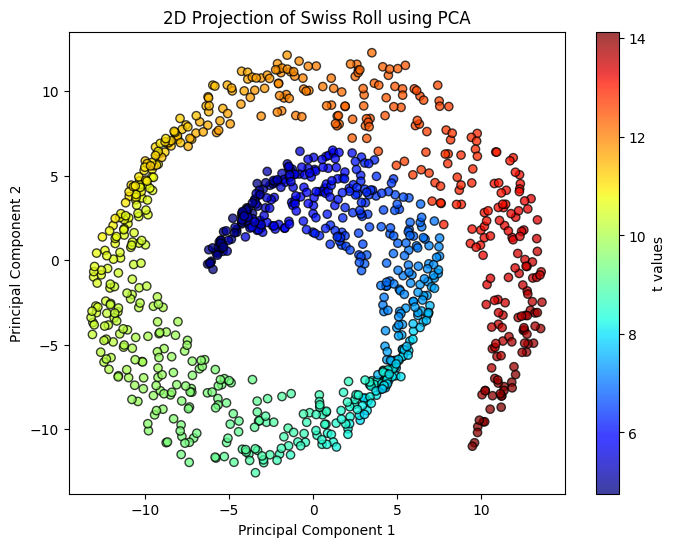

In [3]:
# The first tool to use is a Principal Component Analysis (PCA) from scikit-learn
from sklearn.decomposition import PCA

# Generate the objetc and set the amount of dimensions to project to 2
pca = PCA(n_components=2)

# Fit PCA to the Swiss Roll data and transform it into 2D
X2D = pca.fit_transform(X)

def plot_2D_projection(X2D):
    plt.figure(figsize=(8, 6))
    # Scatter plot of the 2D projection
    # - c=t colors points based on original unrolled position
    # - cmap="jet" provides colorful gradient
    # - edgecolor='k' outlines the points
    plt.scatter(X2D[:, 0], X2D[:, 1],
                c=t, cmap=plt.get_cmap("jet"),
                edgecolor='k', alpha=0.75)
    # Axis labels and title
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("2D Projection of Swiss Roll using PCA")
    # Colorbar for visualizing t-values
    plt.colorbar(label="t values")
    plt.show()


# Plot the data using the defined function
plot_2D_projection(X2D)

In [4]:
# Display the percentage of variance explained by each of the two principal components
print(pca.explained_variance_ratio_)

# Calculate the total variance preserved by projecting the data into 2D
data_preserved = pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]
print(data_preserved)

[0.40782396 0.3020019 ]
0.7098258574944845


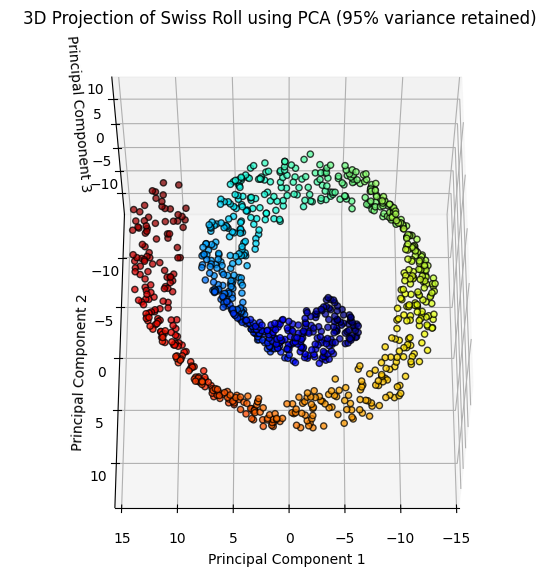

In [5]:
# The initial PCA projection to 2D preserved only 70.9% of the variance,
# meaning that approximately 29.1% of the information was lost.
# To reduce information loss, we'll now apply PCA with enough components
# to preserve at least 95% of the variance in the data.

pca95 = PCA(n_components=0.95)
X3D = pca95.fit_transform(X)

# Create a 3D scatter plot of the PCA projection
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X3D[:, 0], X3D[:, 1], X3D[:, 2], c=t, cmap=plt.get_cmap("jet"), edgecolor='k', alpha=0.75)

# Set axis labels and plot title
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.set_title("3D Projection of Swiss Roll using PCA (95% variance retained)")

# Adjust the viewing angle for better visualization
ax.view_init(elev=60, azim=90)

# Display the plot
plt.show()

In [6]:
# As we can see the projection is still in 3 dimentions
print(pca95.explained_variance_ratio_)

[0.40782396 0.3020019  0.29017414]


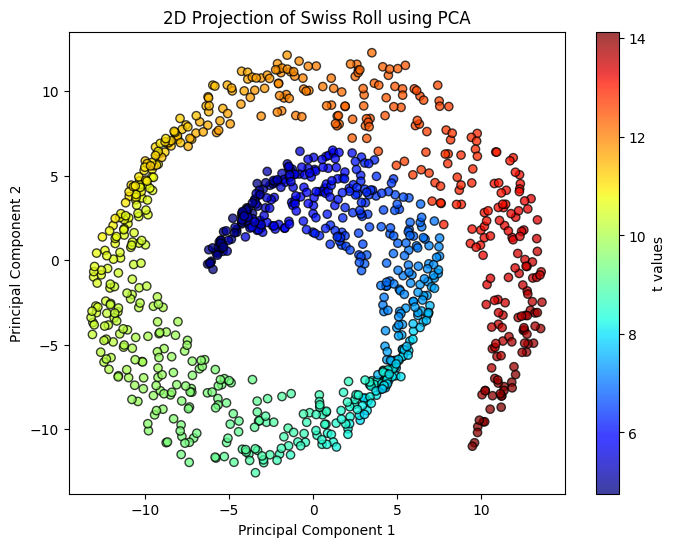

[0.40782396 0.3020019 ]


In [7]:
# Let's try an alternative approach by using a different SVD solver within PCA.
# The "randomized" solver is generally faster for large datasets and can give
# a good approximation of the principal components.

rnd_pca = PCA(n_components=2, svd_solver="randomized")
rnd_X2D = rnd_pca.fit_transform(X)

# Visualize the 2D projection obtained using randomized PCA
plot_2D_projection(rnd_X2D)

# Display the proportion of variance explained by each of the two components
print(rnd_pca.explained_variance_ratio_)

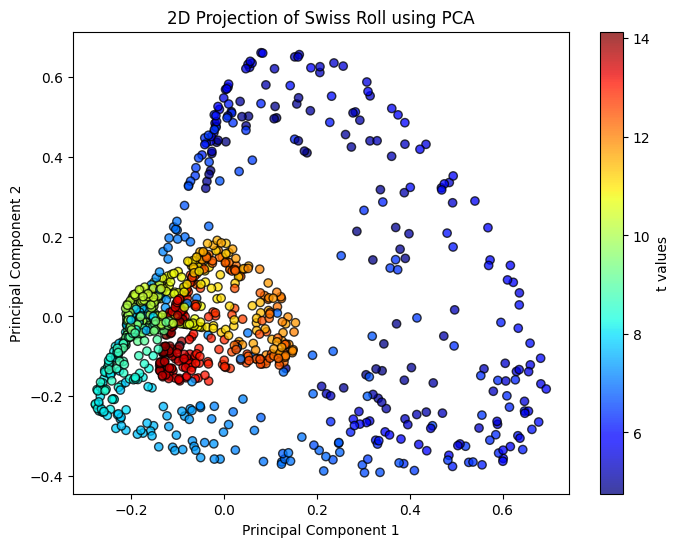

Approximate explained variance ratio: [0.06007999 0.04536731]


In [8]:
# Try using Kernel PCA with a Radial Basis Function (RBF) kernel
# Kernel PCA is useful for capturing nonlinear structures like the Swiss Roll

from sklearn.decomposition import KernelPCA
from sklearn.metrics.pairwise import rbf_kernel

# Apply Kernel PCA with RBF kernel and a specified gamma value
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
rbf_X2D = rbf_pca.fit_transform(X)

# Visualize the 2D projection obtained through nonlinear transformation
plot_2D_projection(rbf_X2D)

# Compute the RBF kernel matrix for the dataset
K = rbf_kernel(X, gamma=0.04)

# Manually compute the eigenvalues of the kernel matrix to estimate variance
eigenvalues = np.linalg.eigvalsh(K)
eigenvalues = np.sort(eigenvalues)[::-1]  # Sort eigenvalues in descending order

# Estimate the proportion of variance captured by the first two components
explained_variance_ratio_approx = eigenvalues[:2] / np.sum(eigenvalues)

# Output the approximate explained variance ratio for the top 2 components
print("Approximate explained variance ratio:", explained_variance_ratio_approx)

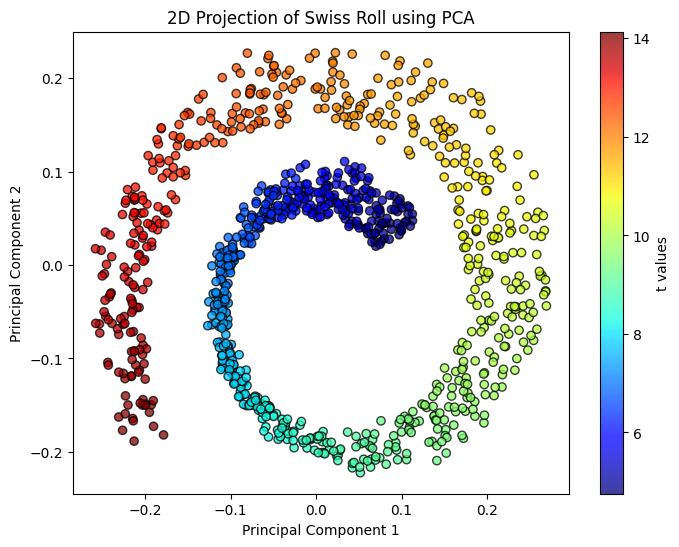

Approximate explained variance ratio: [0.89937118 0.12640246]


In [9]:
# Apply Kernel PCA using a Sigmoid kernel to explore its ability to unfold the Swiss Roll structure
from sklearn.decomposition import KernelPCA
from sklearn.metrics.pairwise import sigmoid_kernel

# Perform Kernel PCA with sigmoid kernel (note: gamma and coef0 are hyperparameters)
sigmoid_pca = KernelPCA(n_components=2, kernel="sigmoid", gamma=0.001, coef0=1)
sigmoid_X2D = sigmoid_pca.fit_transform(X)

# Visualize the 2D projection obtained from the sigmoid kernel transformation
plot_2D_projection(sigmoid_X2D)

# Compute the sigmoid kernel matrix for the original dataset
K = sigmoid_kernel(X, gamma=0.01, coef0=1)  # Slightly different gamma used for kernel matrix estimation

# Manually compute and sort eigenvalues to approximate explained variance
eigenvalues = np.linalg.eigvalsh(K)
eigenvalues = np.sort(eigenvalues)[::-1]

# Estimate the proportion of total variance captured by the first two components
explained_variance_ratio_approx = eigenvalues[:2] / np.sum(eigenvalues)

# Output the estimated variance ratio
print("Approximate explained variance ratio:", explained_variance_ratio_approx)

# Final observation: linear and kernel PCA methods are not ideal for unrolling highly nonlinear manifolds like the Swiss Roll